# Error analysis and conservative properties of numerical SDEs 1: Euler-Maruyama

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import ipyparallel as ipp

# use latex in the notebook. Might casue trouble if pc do not have such latex packages
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsfonts} \usepackage{amsmath} \usepackage{bm}')

# generate high quality figures in notebook
%config InlineBackend.figure_format = 'retina'

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Basic equation

The equation I plan to solve in this project is the following Stratonovich SDE:

\begin{align}
    \mathrm{d} {v} 
    = \left(I-\dfrac{{vv}}{v^2}\right) \circ \mathrm{d}{\boldsymbol{\mathcal{W}}}, 
    \label{SDE}
\end{align}

where $v=(v_x,v_y)$ is 2D; $\boldsymbol{\mathcal{W}}=(\mathcal{W}_x, \mathcal{W}_y)$ is a standard  2D Wiener process. The equation above have a converved quantity: the magnitude of velocity $|v|$. The corresponding Ito SDE is:

\begin{align}
\mathrm{d} {v} 
= -\dfrac{{v}}{2 v^2} \mathrm{d}t + \left(I-\dfrac{{vv}}{v^2}\right)\mathrm{d}\boldsymbol{\mathcal{W} }.
\end{align}

For the convience of numerical solution, we need to write the equation in component form:

\begin{align}
    \begin{pmatrix}\mathrm{d} v_x \\ \mathrm{d}v_y\end{pmatrix}
    = -\dfrac{1}{2(v_x^2+v_y^2)}\begin{pmatrix}v_x \\ v_y\end{pmatrix} \mathrm{d}t + 
    \dfrac{1}{v_x^2+v_y^2}
    \begin{pmatrix}
    v_y^2 & -v_x v_y \\
    -v_x v_y & v_x^2
    \end{pmatrix}
    \begin{pmatrix}
        \mathrm{d} \mathcal{W}_x \\ \mathrm{d} \mathcal{W}_y
    \end{pmatrix}.
    \label{SDE_component}
\end{align}

The initial condition I choose is $(v_x,v_y)=(1,0)$ at $t=0$, the simulation runs in $t\in[0,1]$. Theoretically, the magnitude of velocity $|v|=\sqrt{v_x^2+v_y^2}$ should be conserved.

## Error analysis

### Strong and weak error

Two types of errors are usually used to analyze a numerical scheme: the strong error and the weak error. For a numerical calculation from $t\in[0,T]$, let $X_t^{\Delta t}$ be the numerical solution of the SDE with step size $\delta t$ and $X_t$ be the exact solution, then we have the following definitions:

If ${\displaystyle \max _{0 \leq t \leq T} \mathbb{E}\left|X_{t}^{\Delta t}-X_{t}\right| \leq C(\Delta t)^{\alpha}}$, where $C$ is a constant, $E$ means the expectation value, then $\{X^{\Delta t}_t\}$ strongly converges to $X_t$ with the order $\alpha$; or the scheme has (global) strong error with the order of $\alpha$.

If ${\displaystyle \max _{0 \leq t \leq T}\left|\mathbb{E} f\left(X_{t}^{\Delta t}\right)-\mathbb{E} f\left(X_{t}\right)\right| \leq C_{f}(\Delta t)^{\beta}}$, for any $f \in C_{b}^{\infty}\left(\mathbb{R}^{n}\right)$, where $C_f$ is constant, then $\{X^{\Delta t}_t\}$ weakly converges to $X_t$ with the order $\beta$; or the scheme has (global) weak error with the order of $\beta$.

Notice in practical use, we usually only look at the error at $t=T$ and choose $f(x)=x$ to examine the errors. For a 2D vector ${A}=(A_1,A_2)$, the norm is defined by:

\begin{align}
|{A}| := \sqrt{A_1^2+A_2^2}
\end{align}

### Error of velocity magnitude

Similar to the strong and weak error of the algorithm, we could also define the strong and weak error of velocity magnitude. Let $v_t^{\Delta t}$ be the numerical velocity at time $t$ with time step $\Delta t$; $v_t$ be the exact solution, then similarly we have:
\begin{align}
\begin{split}
\epsilon_{v,\text{strong}} &:= \max _{0 \leq t \leq T} \mathbb{E}\Big| \left|v_{t}^{\Delta t}\right| - |v_{t}|\Big|, \\
\epsilon_{v,\text{weak}} &:= \max _{0 \leq t \leq T}\left|\mathbb{E} f\Big(\left|v_{t}^{\Delta t}\right|\right)-\mathbb{E} f\left(|v_{t}|\right)\Big|
\end{split}
\end{align}

## Numerical verification of errors

In practice when we do not know the analytical solution of an equation, direct calculation of $X_t$ could be difficult. Thus we use an alternative way to calculate these errors. The trick is not only calculate some particular time step $\Delta t$, but calculate a series of time step $\{ \Delta t_l\}, l=0,1,2...; \Delta t_{l+1}<\Delta t_l$. For example, in this project, I set:
\begin{align}
\Delta t_l = 2^{-l}, l=0, 1, .., 10
\end{align}

Because we're solving SDE, we need to guarantee that for different $\Delta t_l$, we're solving the same random process. Thus we need to build up the Wiener process $W_t$ corresponding the smallest $\Delta t$. In our cases, we randomly generate the increment:

\begin{align}
\Delta W^{10}_i \, \stackrel{\text{i.i.d.}}{\sim}\, \mathcal{N}(0, 2^{-10})
\end{align}

Then we build up the process with larger time step based on the process with the smallest time step. For example, the increment of $W_t^9$ could be build up by the following way:

\begin{align}
\Delta W^{9}_i = \sum_{j=2i}^{2i+1} \Delta W_j^{10} \, \stackrel{\text{i.i.d.}}{\sim}\, \mathcal{N}(0, 2^{-9})
\end{align}

In general $\Delta t_l = 2^{-l}, l\leq 10$, let $k=2^{10-l}, $we have:

\begin{align}
\Delta W^{l}_i = \sum_{j= k i }^{k i + k-1} \Delta W_j^{10} \, \stackrel{\text{i.i.d.}}{\sim}\, \mathcal{N}(0, 2^{-l})
\end{align}


Since we have build up a Wiener process that could be used for various different time step, now we can estimate the strong and weak error without exact solution. If an numerical scheme, ${X}_t^{\Delta t}$ have order $\alpha$ strong error and order $\beta$ weak error defined in the previous section, then we can define the following two quantities:

\begin{align}
\begin{split}
\epsilon_\text{strong}^l &:= \mathbb{E}\left|X_{T}^{\Delta t_{l+1}} - X_{T}^{\Delta t_{l}}\right|, \\
\epsilon_\text{weak}^l &:= \left|\mathbb{E} X_{T}^{\Delta t_{l+1}} - \mathbb{E}X_{T}^{\Delta t_{l}}\right|.
\end{split}
\end{align}

It is possible to prove that ${\displaystyle \epsilon_\text{strong}^l  \leq 2 C(\Delta t_{l})^{\alpha}}$, ${\displaystyle \epsilon_\text{weak}^l  \leq 2 C(\Delta t_{l})^{\beta}}$, i.e., they have the same asymptotic behavior as the true strong and weak error. Because we don't need the exact value to calculate these two values, it could be verified by numerical calculation. 

Finally, to calculate the mathematical expectation, we need to build up $M$ independent Wiener processes, labeled by $\alpha$: $\{W_{t,\alpha}\}, \alpha=1,...,M$. We need to solve the SDE for all $\{W_{t,\alpha}\}$. In this project I choose $M=10^6$.

## Step up basic parameters and parallelization

In [4]:
# start parallel computing, using ipyparallel
# need to run the cmd `ipcluster start -n X` in terminal, here X is the number of cores
rc = ipp.Client()
print(rc.ids)
n_core = len(rc.ids)
dview = rc[:]

[0, 1, 2, 3, 4, 5]


In [6]:
# # put in n_core of not parallel runing
# n_core = 6

In [8]:
# Basic parameters
l_max = 10
dt_min = 1./(2.**l_max) # minimum time step, dt_min = 2^{-l_max} 
T = 1. # total time
L_max = int(T/dt_min)  # max number of steps
M = 1000000  # number of different Wiener processes
M_per_core = int(M/n_core)  # number of different Winer process per core
v_0 = np.array([1.0,0]) # initial velocity

# create a dict to easily transmit to each core.
basic_parameters = dict(
l_max = l_max, 
dt_min = dt_min, 
T = T,
L_max = L_max,
M = M,
M_per_core = M_per_core,
v_0 = v_0
)

## The Euler-Maruyama method

The simplest scheme is the Euler-Maruyama method, which is given by:

\begin{align}
X_{n+1}=X_{n}+a\left(X_{n}, t_n\right) \Delta t + b\left(X_{n}, t_n\right) \Delta W_{n}, 
\end{align}

where $\Delta W_{n} \sim \mathcal{N}\left(0, \Delta t\right)$; $\Delta t$ is the time step. It has a global strong error $\mathcal{O}(\sqrt{\Delta t})$ and weak error $\mathcal{O}({\Delta t})$. Applying to our equation $\eqref{SDE_component}$, we get the numerical scheme:

\begin{align}
    \begin{pmatrix} v_{n+1,x} \\  v_{n+1,y} \end{pmatrix} = 
    \begin{pmatrix} v_{n,x} \\  v_{n,y} \end{pmatrix}
    -\dfrac{1}{2(v_{n,x}^2+v_{n,y}^2)}\begin{pmatrix}v_{n,x} \\ v_{n,y}\end{pmatrix} \Delta t + 
    \dfrac{1}{v_{n,x}^2+v_{n,y}^2}
    \begin{pmatrix}
    v_{n,y}^2 & -v_{n,x} v_{n,y} \\
    -v_{n,x} v_{n,y} & v_{n,x}^2
    \end{pmatrix}
    \begin{pmatrix}
        \Delta \mathcal{W}_x \\ \Delta \mathcal{W}_y
    \end{pmatrix}.
    \label{numerical_scheme}
\end{align}

Here $\Delta \mathcal{W}_x, \Delta \mathcal{W}_y \sim \mathcal{N}\left(0, \Delta t\right)$ are identical independent normal distribution. 

In [6]:
# define the function to calculate reuslts
def Euler_Maruyama():
    
    # import package for each core
    import numpy as np
    import time

    # calculate the result for M different Wiener processes with l_max different time steps.
    np.random.seed(random_seed)

    # The final results are saved in one dict.
    EM = {}

    # timer
    t1 = time.time()

    # print where the calculation is
    tag = 0

    # Go through all M different Wiener processes
    for i in range(M_per_core):

        # pick up a Wiener process
        dw_x = np.random.normal(0,np.sqrt(dt_min),L_max)
        dw_y = np.random.normal(0,np.sqrt(dt_min),L_max)

        # initalize the sub-dict for this Wiener process
        EM[i] = {}

        # go through different time step
        for l in range(l_max+1):

            # initial the sub-dict for this time step
            EM[i][l] = {}

            # build up the Weiner process for this particular time step, dt = 2^{-l}
            dt = 2.**(-l)
            k = 2**(l_max-l)
            L = int(L_max / k)
            dw_x_2 = np.sum(np.reshape(dw_x,(L, k)),axis=1)
            dw_y_2 = np.sum(np.reshape(dw_y,(L, k)),axis=1)

            # initialize the data set for v_x and v_y
            vx = np.zeros(L+1)
            vy = np.zeros(L+1)

            vx[0] = v_0[0]
            vy[0] = v_0[1]

            # go through each step with dt = 2^{-l}, total step is L
            for j in range(L):

                # calculate v_x^2, v_y^2, v^2 and v_x\times v_y, to speed up the calculation
                vx2 = vx[j]**2
                vy2 = vy[j]**2
                vm = vx2 + vy2 
                v_cross = vx[j] * vy[j]

                # calculate equation 13
                ( vx[j+1], vy[j+1] ) = ( 1. - ( dt / (2.*vm ) ) ) * np.array([vx[j], vy[j]]) \
                                        + np.array([ vy2 * dw_x_2[j] - v_cross*dw_y_2[j], 
                                                    - v_cross*dw_x_2[j] + vx2 * dw_y_2[j] ]) / vm


            # save the result into dict
            # for the first one, save the whole path;
            # for others, only save the final result
            if  i == 0:
                EM[i][l]['vx'] = vx
                EM[i][l]['vy'] = vy
                EM[i][l]['t'] = np.arange(0,T+dt,dt)
            else:
                EM[i][l]['vx'] = vx[-1]
                EM[i][l]['vy'] = vy[-1]
                
    return EM

In [7]:
# Send the constants to each core
dview.push(basic_parameters)

# Set different random seeds for each core
dview.scatter('random_seed',np.arange(n_core))

# run in parallel
t1 = time.time()
EM_results = dview.apply(Euler_Maruyama).get()
t2 = time.time()
print(t2-t1)

3.369384765625


In [6]:
# # save the result to file
# with open('./data/EM.pickle', 'wb') as handle:
#     pickle.dump(EM_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# load the saved result from file

with open('./data/EM.pickle', 'rb') as handle:
    EM_results = pickle.load(handle)

### Straightforward statistics and visualization

Before calculating the strong and weak error, I will do some Straightforward visualization to show the results.

The first thing we could verify is the so-called path-wise convergence. It shows the time evolution (the path) of the result corresponding to one Wiener process with different time step. If the the path converge when time step decrease, then we say it is path-wise convergent. This is a straight forward test to visualize and is closely related to strong convergence.

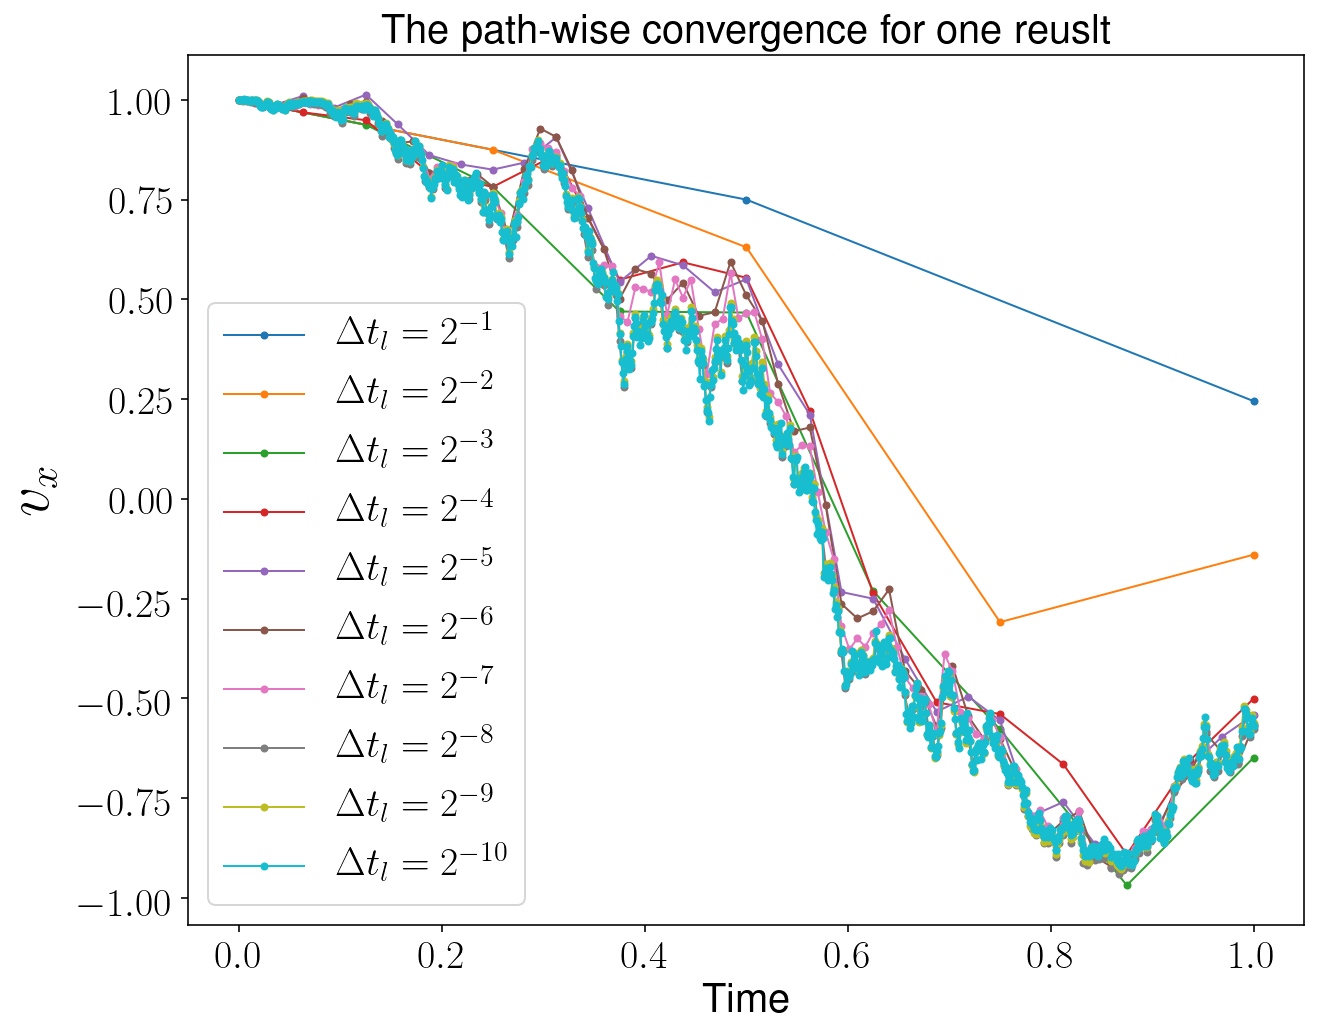

In [10]:
# path-wise

EM = EM_results[0]

# calculation of pathwise convergent.
plt.figure(figsize=(10,8))
for l in [1,2,3,4,5,6,7,8,9,10]:
    plt.plot(EM[0][l]['t'], EM[0][l]['vx'], label='$\Delta t_l = 2^{-%i}$' % l, \
             marker='o', markersize=3, linewidth=1)
    
plt.legend(fontsize=20);plt.xticks(fontsize=20);plt.yticks(fontsize=20);
plt.title('The path-wise convergence for one reuslt', fontsize=20);
plt.xlabel('Time',fontsize=20); plt.ylabel('$v_x$',fontsize=30);

# save fig
plt.savefig('./fig/EM_path_wise.pdf')

The second thing we could do is show the distribution of $M$ different particles. Here I used two figures to demonstrate. The first is in $v_x - v_y$ plan, where each particle is represented by one point. The second is the histogram of distribution of $\theta\in[-\pi,\pi]$, which is the scattering angle.

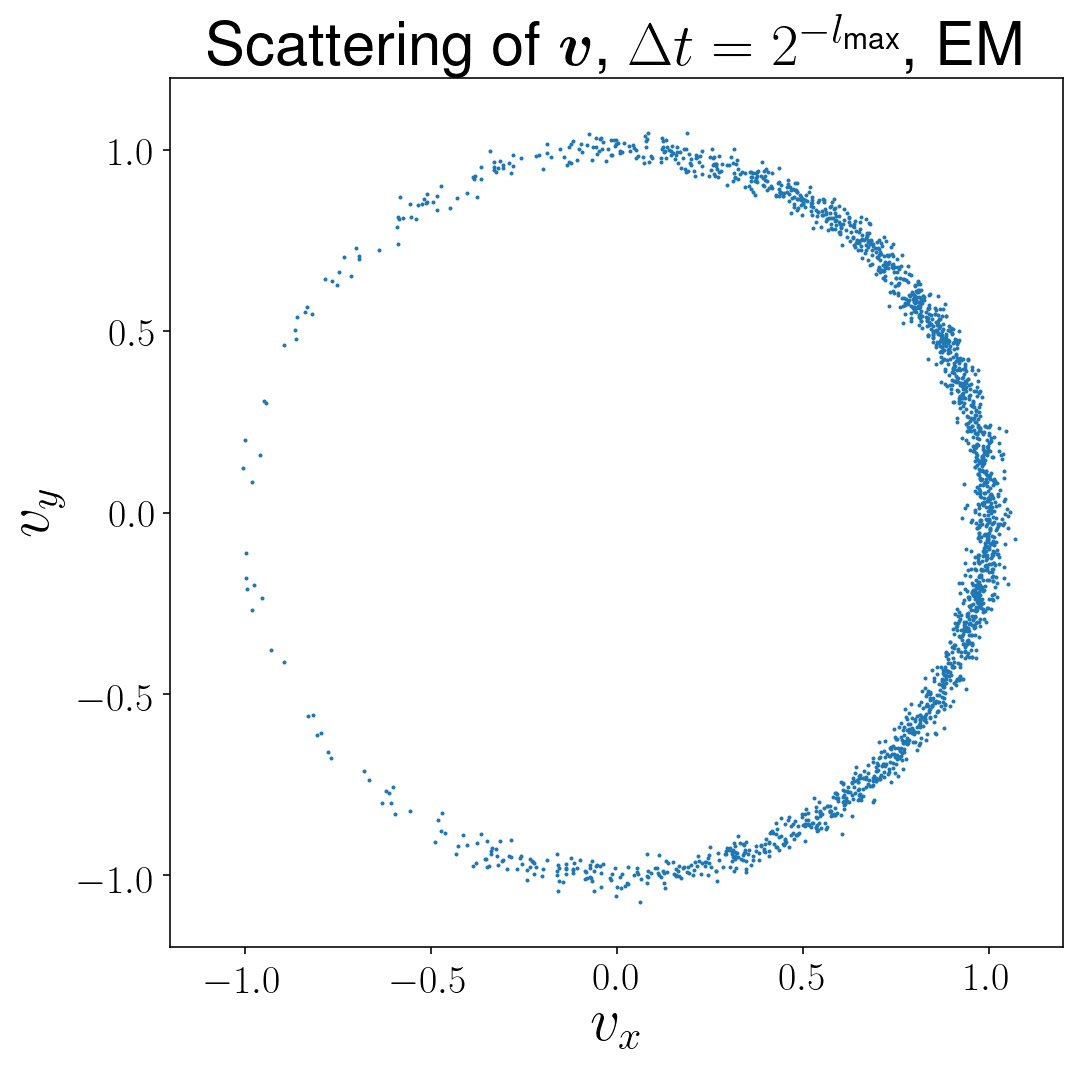

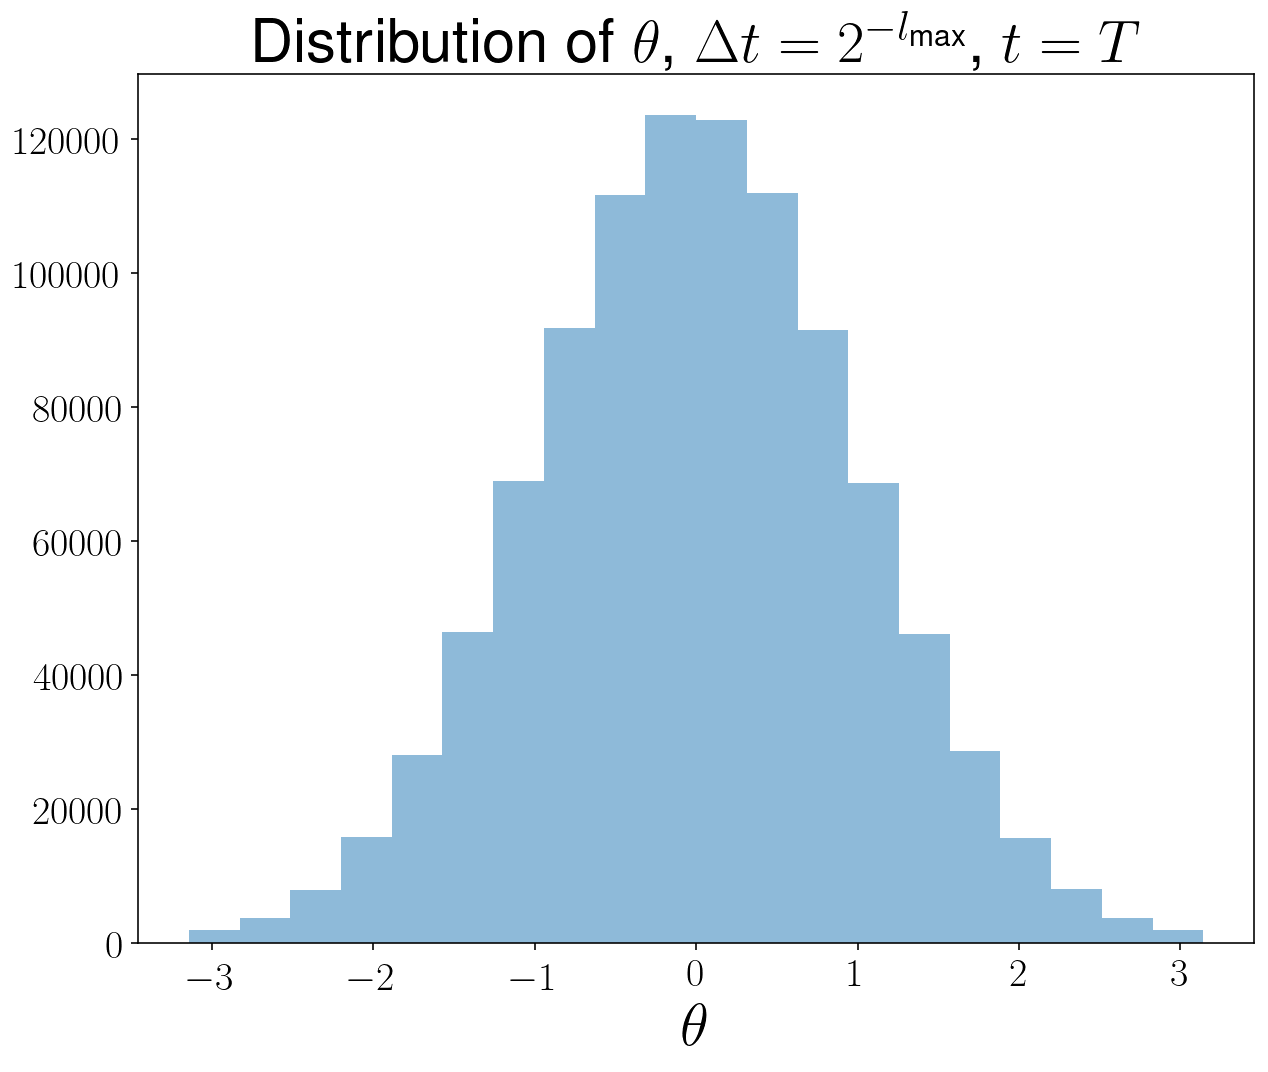

In [12]:
# vx-vy space distribution
vx_final = np.array([])
vy_final = np.array([])

for alpha in range(n_core):
    # extract the position of particles at certain time
    EM = EM_results[alpha]
    vx_final = np.append( vx_final, np.array([ EM[i][10]['vx'] for i in range(1,M_per_core) ]) )
    vy_final = np.append( vy_final, np.array([ EM[i][10]['vy'] for i in range(1,M_per_core) ]) )
theta = np.angle( vx_final + 1.j*vy_final )

# plot the scattering of particles in vx-vy plane,
# maximum 2000 particles
plt.figure(figsize=(8,8))
plt.scatter(vx_final[:np.minimum(2000,M)],vy_final[:np.minimum(2000,M)],s=1)
plt.xlabel(r'$v_x$',fontsize=30)
plt.ylabel(r'$v_y$',fontsize=30)
plt.title(r'Scattering of $\boldsymbol{v}$, $\Delta t = 2^{-l_\text{max}}$, EM',fontsize=30)
plt.xticks(fontsize=20);plt.yticks(fontsize=20);
plt.xlim([-1.2,1.2]); plt.ylim([-1.2,1.2]);

# save fig
plt.savefig('./fig/EM_2D_scattering.pdf')

# plot the distribution of theta
plt.figure(figsize=(10,8))
plt.hist(theta,20, alpha=0.5)
plt.xlabel(r'$\theta$',fontsize=30)
plt.title(r'Distribution of $\theta$, $\Delta t = 2^{-l_\text{max}}$, $t=T$',fontsize=30)
plt.xticks(fontsize=20);plt.yticks(fontsize=20);

# save fig
plt.savefig('./fig/EM_theta_hist.pdf')

### Strong and weak convergence

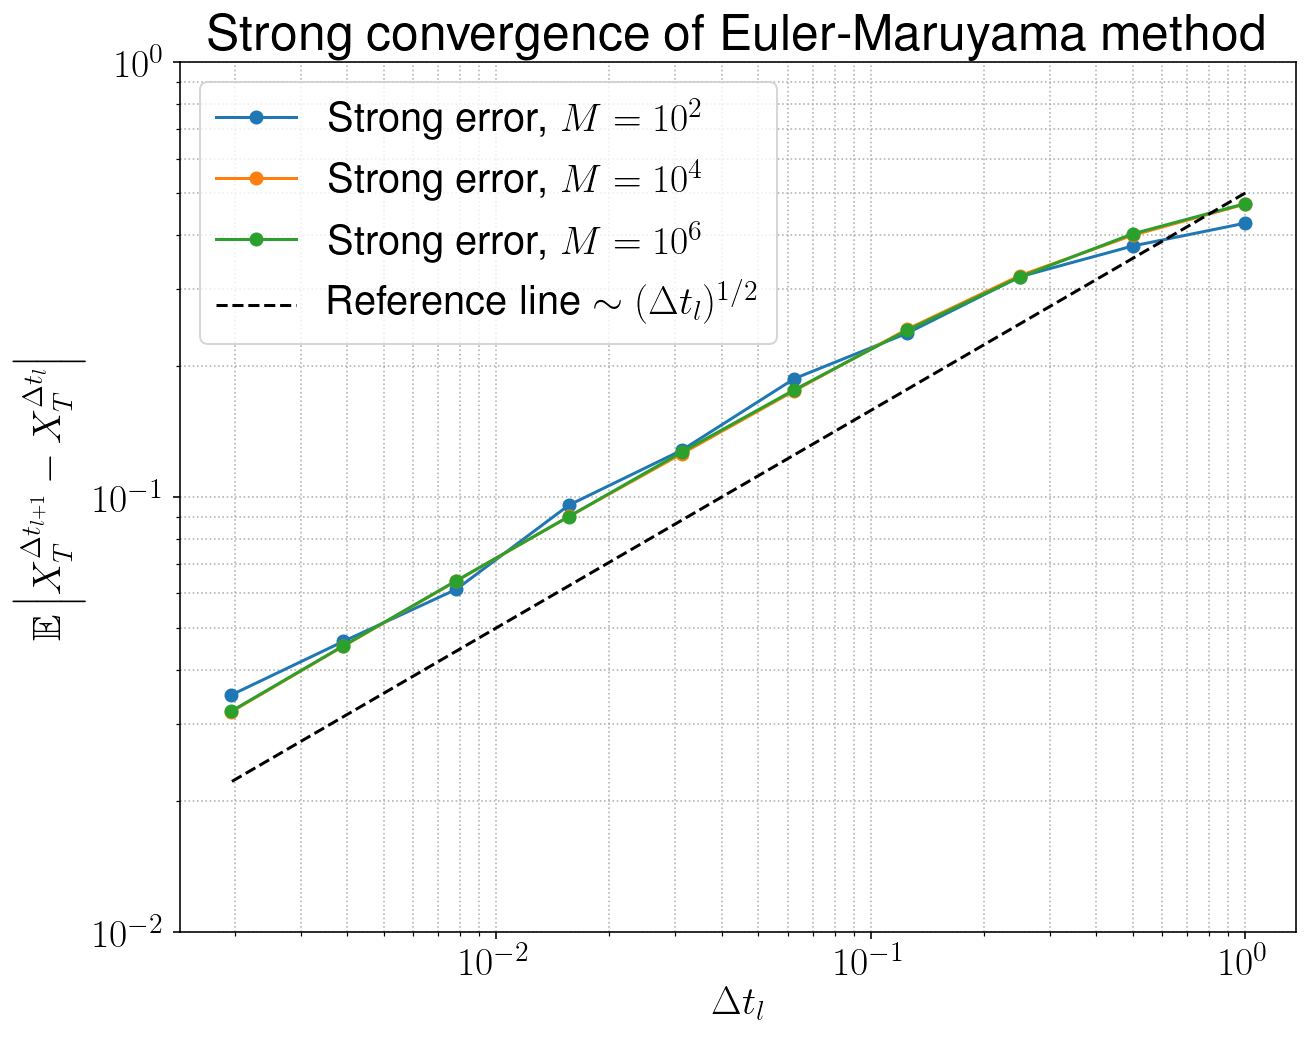

In [21]:
# calculate the stong convergence based on the result EM.
plt.figure(figsize=(10,8))

# initialize the result of strong convergence
dt_list = np.array([ 2.**(-l) for l in range(l_max) ])

# create a reference line for order 1/2 convergence
ref = np.array([ 0.5*dt**(0.5) for dt in dt_list ])

# test the result for different number of particles
for M_max in [100, 10000, 1000000]:
    
    # initialize 
    e_strong = np.zeros((l_max))

    # go through all dt = 2^{-l}   
    for l in np.arange(l_max):
        
        epsilon = 0.
        count = 0

        # go through all independent processes
        for alpha in range(n_core):

            EM = EM_results[alpha]

            for i in range(1,M_per_core):
                
                # only calculate M < M_max
                if count > M_max:
                    break
                    
                count += 1

                epsilon += np.sqrt( (EM[i][l]['vx'] - EM[i][l+1]['vx'])**2 \
                                   + (EM[i][l]['vy'] - EM[i][l+1]['vy'])**2 )

        e_strong[l] = epsilon / count

    # plot the data
    plt.plot(dt_list,e_strong,marker='o', label='Strong error, $M= 10^{%i}$' % np.log10(M_max))

# settings for the figure
plt.plot(dt_list,ref, color='k', linestyle='--', label='Reference line $\sim (\Delta t_l)^{1/2}$')
plt.xscale('log'); plt.yscale('log'); plt.legend(fontsize=20);
plt.ylim([1e-2,1]); 
plt.grid(which='both',linestyle=':')
plt.xticks(fontsize=20);plt.yticks(fontsize=20);
plt.xlabel('$\Delta t_l$',fontsize=20);
plt.ylabel(r'$\mathbb{E}\left|X_{T}^{\Delta t_{l+1}} - X_{T}^{\Delta t_{l}}\right|$',fontsize=20);
plt.title('Strong convergence of Euler-Maruyama method', fontsize=25);

# save fig
plt.savefig('./fig/EM_strong.pdf')

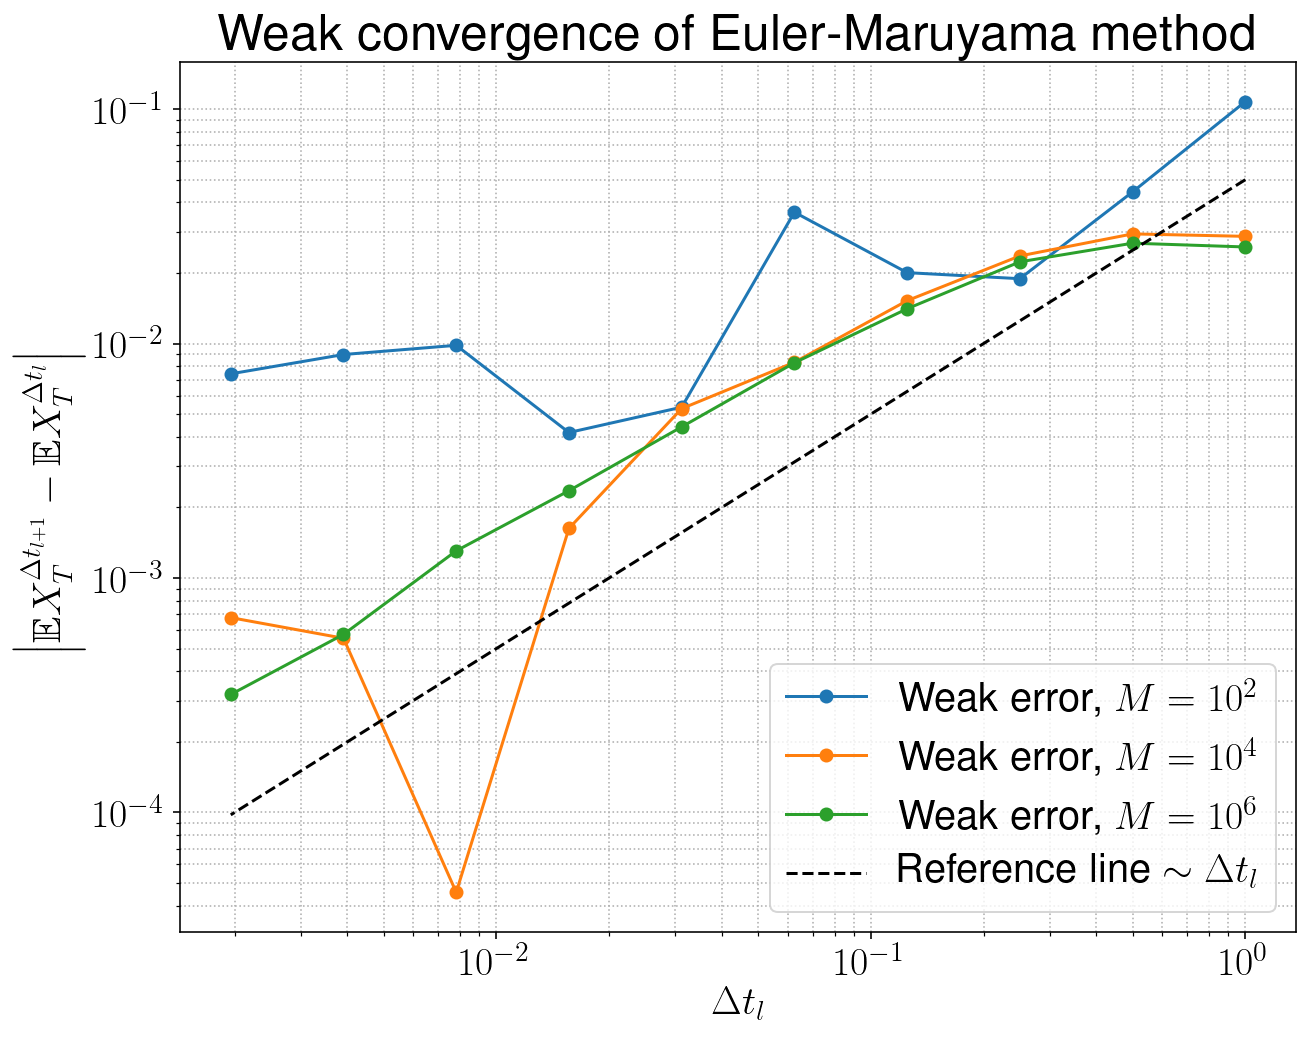

In [26]:
# calculate the weak convergence of MP
plt.figure(figsize=(10,8))

dt_list = np.array([ 2.**(-l) for l in range(l_max) ])

# create a reference line for order 1 convergence
ref = np.array([ 0.05*dt for dt in dt_list ])

# test different M
for M_max in [100, 10000, 1000000]:

    # initialize the weak error and expectation of all dt^l
    e_weak = np.zeros((l_max))
    Evx = np.zeros((l_max+1))
    Evy = np.zeros((l_max+1))

    # go through all dt = 2^{-l} to calculate expectation
    for l in np.arange(l_max+1):
        vx = 0.
        vy = 0.
        count = 0

        # go through all independent processes
        for alpha in range(n_core):
            EM = EM_results[alpha]

            for i in range(1,M_per_core):
                
                count += 1
                if count > M_max:
                    break

                vx += EM[i][l]['vx']
                vy += EM[i][l]['vy']

        # averaging
        Evx[l] = vx / count
        Evy[l] = vy / count

    # calculate weak error
    for l in np.arange(l_max):
        e_weak[l] = np.sqrt( (Evx[l]-Evx[l+1])**2 + (Evy[l]-Evy[l+1])**2 )

    # plot the result
    plt.plot(dt_list, e_weak, marker='o', label='Weak error, $M=10^{%i}$' % np.log10(M_max))

# settings for the figure
plt.plot(dt_list,ref, color='k', linestyle='--', label='Reference line $\sim \Delta t_l$')
plt.xscale('log'); plt.yscale('log'); plt.legend(fontsize=20, loc=4);
plt.grid(which='both',linestyle=':')
plt.xticks(fontsize=20);plt.yticks(fontsize=20);
plt.xlabel('$\Delta t_l$',fontsize=20);
plt.ylabel(r'$\left|\mathbb{E} X_{T}^{\Delta t_{l+1}} - \mathbb{E}X_{T}^{\Delta t_{l}}\right|$',fontsize=20);
plt.title('Weak convergence of Euler-Maruyama method', fontsize=25);

# save fig
plt.savefig('./fig/EM_weak.pdf')

### Error in magnitude of velocity

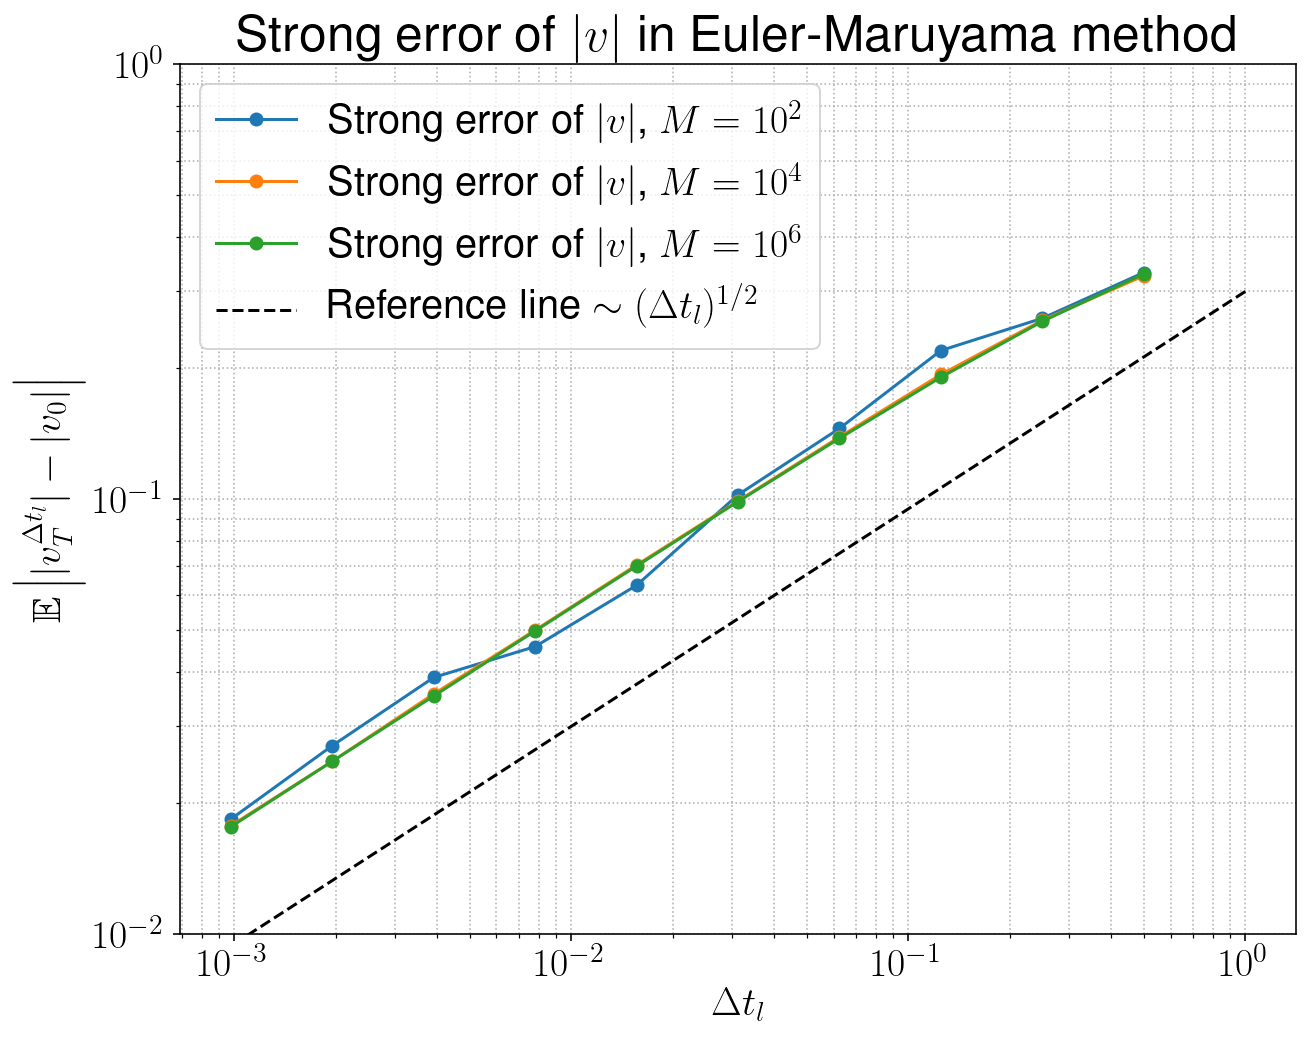

In [40]:
# calculate the stong error of |v| based on the result EM.
plt.figure(figsize=(10,8))

dt_list = np.array([ 2.**(-l) for l in range(l_max+1) ])

for M_max in [100, 10000, 1000000]:
    
    # initialize the result of strong convergence
    e_strong = np.zeros((l_max+1))

    # go through all dt = 2^{-l}   
    for l in np.arange(1, l_max+1):
        
        epsilon = 0.
        count = 0

        # go through all independent processes
        for alpha in range(n_core):

            EM = EM_results[alpha]

            for i in range(1,M_per_core):
                
                if count > M_max:
                    break

                epsilon += np.abs( np.sqrt( EM[i][l]['vx']**2 + EM[i][l]['vy']**2 ) - 1. )
                count += 1

        e_strong[l] = epsilon / count

    plt.plot(dt_list[1:], e_strong[1:], marker='o', label='Strong error of $|v|$, $M=10^{%i}$' % np.log10(M_max))

# create a reference line for order 1/2 convergence
ref = np.array([ 0.3*dt**(0.5) for dt in dt_list ])

# settings for the figure
plt.plot(dt_list,ref, color='k', linestyle='--', label='Reference line $\sim (\Delta t_l)^{1/2}$')
plt.xscale('log'); plt.yscale('log'); plt.legend(fontsize=20, loc='upper left');
plt.ylim([1e-2,1]); plt.grid(which='both',linestyle=':')
plt.xticks(fontsize=20);plt.yticks(fontsize=20);
plt.xlabel('$\Delta t_l$',fontsize=20);
plt.ylabel(r'$\mathbb{E}\left| |v_{T}^{\Delta t_{l}}| - |v_0| \right|$',fontsize=20);
plt.title('Strong error of $|v|$ in Euler-Maruyama method', fontsize=25);

# save fig
plt.savefig('./fig/EM_v_strong.pdf')

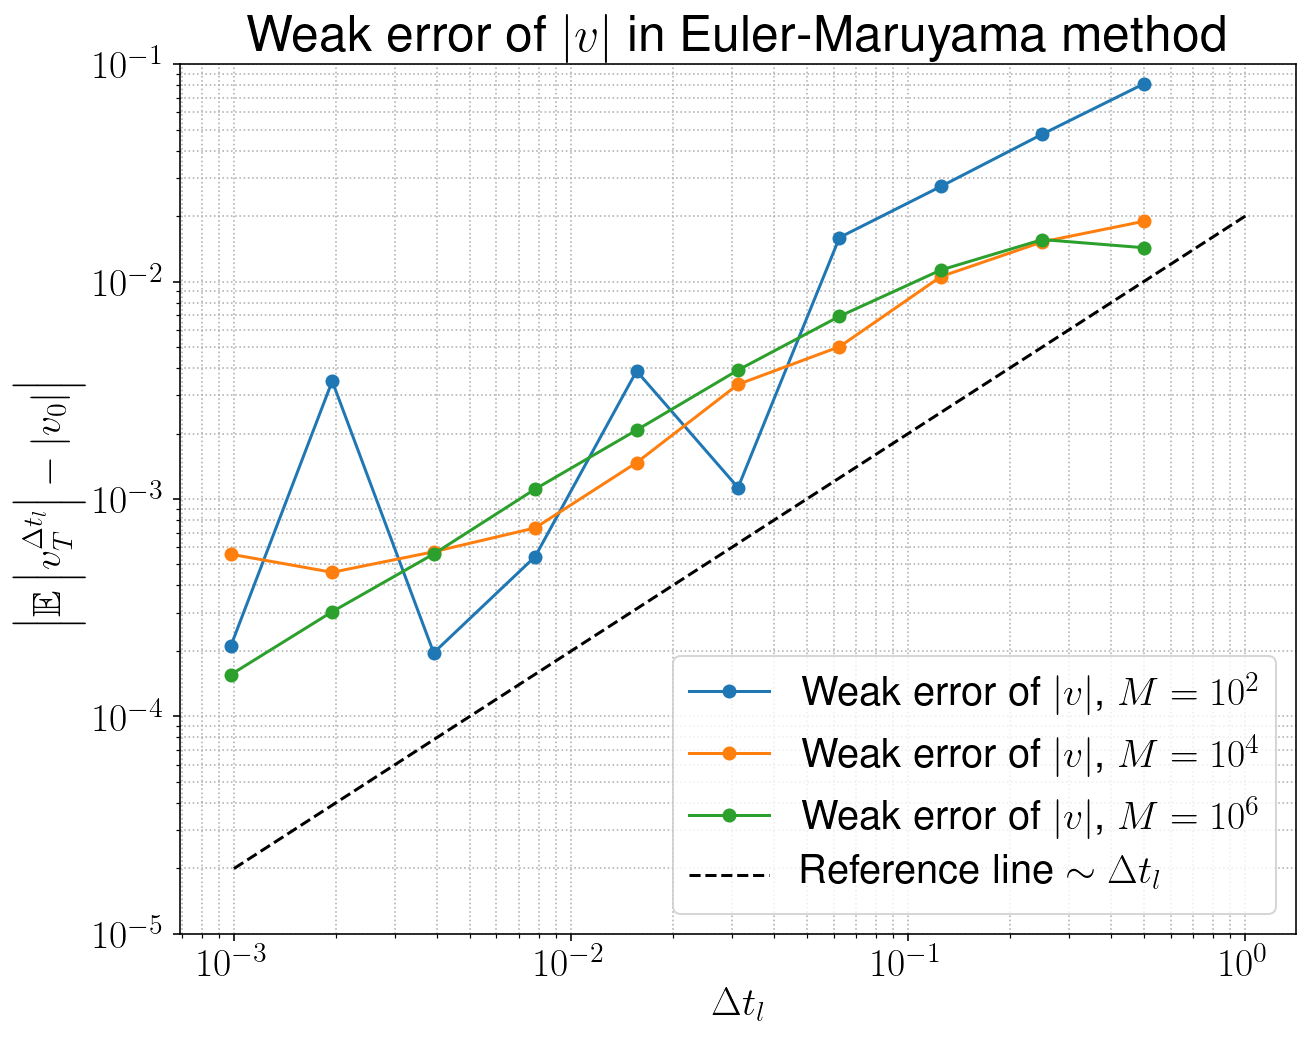

In [46]:
# calculate the weak error of |v| in EM
plt.figure(figsize=(10,8))

dt_list = np.array([ 2.**(-l) for l in range(l_max+1) ])

for M_max in [100, 10000, 1000000]:

    # initialize the weak error and expectation of all dt^l
    e_weak = np.zeros((l_max+1))
    Ev = np.zeros((l_max+1))

    # go through all dt = 2^{-l} to calculate expectation
    for l in np.arange(l_max+1):
        v_magnitude= 0.
        count = 0

        # go through all independent processes
        for alpha in range(n_core):
            EM = EM_results[alpha]

            for i in range(1,M_per_core):
                
                if count > M_max:
                    break

                v_magnitude += np.sqrt( EM[i][l]['vx']**2. + EM[i][l]['vy']**2. )
                count += 1

        # averaging
        Ev[l] = v_magnitude / count

    # calculate weak error
    for l in np.arange(l_max+1):
        e_weak[l] = np.abs( Ev[l] - 1. )

    plt.plot(dt_list[1:], e_weak[1:], marker='o', label='Weak error of $|v|$, $M=10^{%i}$' % np.log10(M_max))

# create a reference line for order 1 convergence
ref = np.array([ 0.02*dt for dt in dt_list ])

# settings for the figure
plt.plot(dt_list,ref, color='k', linestyle='--', label='Reference line $\sim \Delta t_l$')
plt.ylim([1e-5,0.1])
plt.xscale('log'); plt.yscale('log'); plt.legend(fontsize=20);
plt.grid(which='both',linestyle=':')
plt.xticks(fontsize=20);plt.yticks(fontsize=20);
plt.xlabel('$\Delta t_l$',fontsize=20);
plt.ylabel(r'$\left|\mathbb{E} \left| v_{T}^{\Delta t_{l}} \right| -  |v_0| \right|$',fontsize=20);
plt.title('Weak error of $|v|$ in Euler-Maruyama method', fontsize=25);

# save fig
plt.savefig('./fig/EM_v_weak.pdf')

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [11]:
# rc.shutdown(hub=True)